Libraries

In [1]:
import math
import random
from copy import deepcopy
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliFeatureMap
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.datasets import load_iris
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.algorithms import QSVC, PegasosQSVC
from qiskit_ibm_runtime import SamplerV2, QiskitRuntimeService, Session
from qiskit.primitives import StatevectorSampler as Sampler
import pickle

from sklearn.datasets import make_blobs, make_circles, make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
from bayes_opt import BayesianOptimization
import itertools
from typing import Any, Dict, List, Tuple
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

Global parameters

In [9]:
RANDOM_STATE = 42

N_SPLITS = 3
C = 1.0
PEGASOS_NUM_STEPS = 70

REPS = 2
SEQUENCE_LENGTH = 2

SAMPLER = Sampler()
SHOTS = 1024
OPTIMIZATION_LEVEL = 3

N_QUBITS = 4

Datasets

 - Synthetic datasets

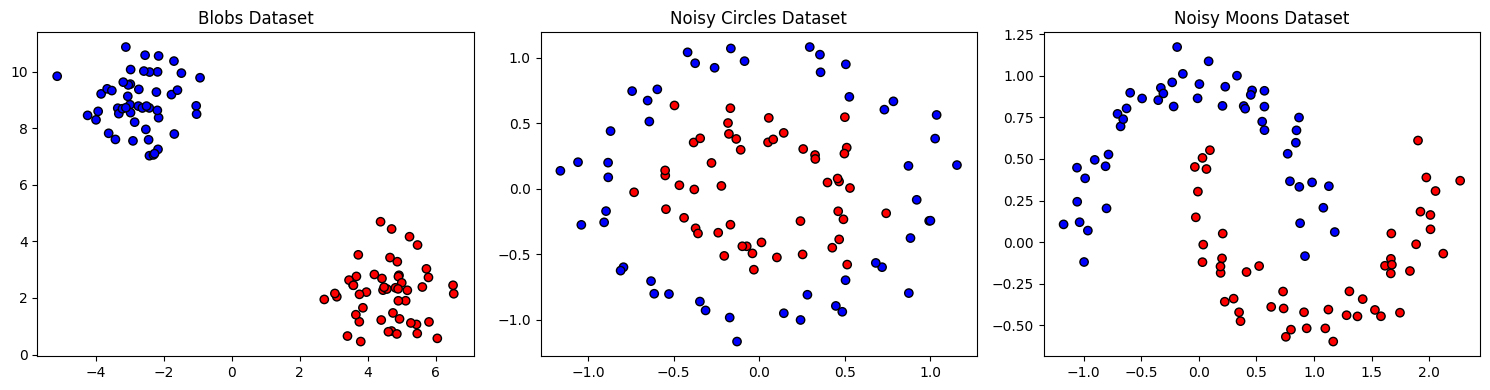

In [2]:
random_state = 42

# Generate the datasets
X_blobs, y_blobs = make_blobs(n_samples=100, centers=2, n_features=2, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=random_state)
X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=random_state)

# Plot the datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='bwr', edgecolors='k')
axes[0].set_title("Blobs Dataset")

axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='bwr', edgecolors='k')
axes[1].set_title("Noisy Circles Dataset")

axes[2].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='bwr', edgecolors='k')
axes[2].set_title("Noisy Moons Dataset")

plt.tight_layout()
plt.show()

Classic evaluation model

In [62]:
# Reproducibility
random_state = 42

# Generate datasets
datasets = {
    "blobs": make_blobs(n_samples=100, centers=2, n_features=2, random_state=random_state),
    "noisy_circles": make_circles(n_samples=100, noise=0.3, factor=0.1, random_state=random_state),
    "noisy_moons": make_moons(n_samples=100, noise=0.3, random_state=random_state),
}

# Define classical models
models = {
    "SVC linear": SVC(kernel='linear', random_state=random_state),
    "SVC poly": SVC(kernel='poly', degree=3, random_state=random_state),
    "SVC rbf": SVC(kernel='rbf', random_state=random_state)
}

# Store results
results = []

# Stratified K-Fold setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Evaluate each model on each dataset
for model_name, model in models.items():
    for dataset_name, (X, y) in datasets.items():
        acc_scores = []
        f1_scores = []

        # Stratified K-Fold loop
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

        results.append({
            "Type": "classical",
            "Model": model_name,
            "Dataset": dataset_name,
            "ACC": f"{acc_mean:.3f} ± {acc_std:.3f}",
            "F1": f"{f1_mean:.3f} ± {f1_std:.3f}"
        })

# Create results table
df_results = pd.DataFrame(results)

# Pivot for nice comparison
df_pivot = df_results.pivot(index=["Type", "Model"], columns="Dataset", values=["ACC", "F1"])

print("\nCross-validated results (mean ± std):\n")
print(df_pivot)



Cross-validated results (mean ± std):

                                ACC                                \
Dataset                       blobs  noisy_circles    noisy_moons   
Type      Model                                                     
classical SVC linear  1.000 ± 0.000  0.540 ± 0.073  0.850 ± 0.089   
          SVC poly    1.000 ± 0.000  0.550 ± 0.071  0.790 ± 0.102   
          SVC rbf     1.000 ± 0.000  0.900 ± 0.095  0.900 ± 0.055   

                                 F1                                
Dataset                       blobs  noisy_circles    noisy_moons  
Type      Model                                                    
classical SVC linear  1.000 ± 0.000  0.619 ± 0.083  0.845 ± 0.099  
          SVC poly    1.000 ± 0.000  0.686 ± 0.041  0.744 ± 0.163  
          SVC rbf     1.000 ± 0.000  0.896 ± 0.100  0.900 ± 0.055  


 - Real dataset

In [6]:
dir = "C:/Users/jiriv/Documents/škola/Diplom_thesis/Quantum-feature-maps/"
dataset_save = f"{dir}Dataset/Toxicity-13F.csv"
dataset_5F = f"{dir}Dataset/Toxicity-5F.csv"
dataset_8F = f"{dir}Dataset/Toxicity-8F.csv"

df = pd.read_csv(dataset_save)
#print(df['Class'].value_counts())
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)
#print(df['Class'].value_counts())
#df.head()

df5 = pd.read_csv(dataset_5F)
#print(df5['Class'].value_counts())
#df5.head()
X5 = df5.drop(columns=['Class']).values
y5 = df5['Class'].values

df8 = pd.read_csv(dataset_8F)

In [7]:
df5 = pd.read_csv(dataset_5F)  # dataset_5F should be defined in your environment
X5 = df5.drop(columns=['Class']).values
y5 = df5['Class'].values

# --- Define models ---
models = {
    "SVC linear": SVC(kernel='linear', random_state=random_state),
    "SVC poly": SVC(kernel='poly', degree=3, random_state=random_state),
    "SVC rbf": SVC(kernel='rbf', random_state=random_state)
}

# --- Stratified K-Fold setup ---
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# --- Evaluate ---
results = []

for model_name, model in models.items():
    acc_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X5, y5):
        X_train, X_test = X5[train_index], X5[test_index]
        y_train, y_test = y5[train_index], y5[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))  # weighted for multiclass safety

    # Aggregate results
    acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
    f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

    results.append({
        "Type": "classical",
        "Model": model_name,
        "Dataset": "df5",
        "ACC": f"{acc_mean:.3f} ± {acc_std:.3f}",
        "F1": f"{f1_mean:.3f} ± {f1_std:.3f}"
    })

# --- Make results table ---
df_results = pd.DataFrame(results)
df_pivot = df_results.pivot(index=["Type", "Model"], columns="Dataset", values=["ACC", "F1"])

print("\nCross-validated results for df5 (mean ± std):\n")
print(df_pivot)


Cross-validated results for df5 (mean ± std):

                                ACC             F1
Dataset                         df5            df5
Type      Model                                   
classical SVC linear  0.673 ± 0.008  0.541 ± 0.011
          SVC poly    0.673 ± 0.008  0.541 ± 0.011
          SVC rbf     0.673 ± 0.008  0.541 ± 0.011


In [90]:
# --- Load Iris dataset ---
iris = load_iris()
X = iris.data
y = iris.target

# --- Keep only two classes (e.g., class 0 and 1) ---
mask = y < 2   # keep Setosa (0) and Versicolor (1)
X_iris_bin = X[mask]
y_iris_bin = y[mask]

# --- Define models ---
models = {
    "SVC linear": SVC(kernel='linear', random_state=random_state),
    "SVC poly": SVC(kernel='poly', degree=3, random_state=random_state),
    "SVC rbf": SVC(kernel='rbf', random_state=random_state)
}

# --- Stratified K-Fold setup ---
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# --- Evaluate ---
results = []

for model_name, model in models.items():
    acc_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X_iris_bin, y_iris_bin):
        X_train, X_test = X_iris_bin[train_index], X_iris_bin[test_index]
        y_train, y_test = y_iris_bin[train_index], y_iris_bin[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))  # binary = default averaging works fine

    # Aggregate results
    acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
    f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

    results.append({
        "Type": "classical",
        "Model": model_name,
        "Dataset": "iris_binary",
        "ACC": f"{acc_mean:.3f} ± {acc_std:.3f}",
        "F1": f"{f1_mean:.3f} ± {f1_std:.3f}"
    })

# --- Make results table ---
df_results_iris_bin = pd.DataFrame(results)
df_pivot_iris_bin = df_results_iris_bin.pivot(index=["Type", "Model"], columns="Dataset", values=["ACC", "F1"])

print("\nCross-validated results for Iris (2 classes, 4 features):\n")
print(df_pivot_iris_bin)



Cross-validated results for Iris (2 classes, 4 features):

                                ACC             F1
Dataset                 iris_binary    iris_binary
Type      Model                                   
classical SVC linear  1.000 ± 0.000  1.000 ± 0.000
          SVC poly    1.000 ± 0.000  1.000 ± 0.000
          SVC rbf     1.000 ± 0.000  1.000 ± 0.000


Bayesian optimization for best pauli feature map

In [46]:
class BayesianOptimizationPFM:
    def __init__(self, X, y, n_qubits, shots, optimization_level, random_state, backend, cv_splits, c, pegasos_num_steps, sequence_length, reps):
        self.X = X    # training features
        self.y = y    # training labels
        self.n_qubits = n_qubits
        self.shots = shots
        self.optimization_level = optimization_level
        self.random_state = random_state
        self.backend = backend
        self.cv_splits = cv_splits
        self.c = c
        self.pegasos_num_steps = pegasos_num_steps
        self.reps = reps
        
        self.sequence_length = sequence_length  # maximum number of Pauli strings per sequence
        all_combinations = self.generate_pauli_possibilities()
        self.pauli_choices = all_combinations  # list of all possible Pauli combinations for qiven n_qubits
        self.entanglement_choices = ['full', 'circular', 'linear', 'reverse_linear']
        # add different alphas
        self.alpha_choices = [0.1, 0.5, 1.0, 2.0]

    def generate_pauli_possibilities(self) -> List[Tuple[str, ...]]:
        paulis = ["X", "Y", "Z"]
        base_paulis = []
        # Step 1: Generate all Pauli strings up to n_qubits
        for r in range(1, self.n_qubits + 1):
            for combo in itertools.product(paulis, repeat=r):
                pauli_str = "".join(combo)
                base_paulis.append(pauli_str)
        
        # Step 2: Generate all sequences of Pauli strings up to `sequence_length
        pauli_choices = []
        for r in range(1, self.sequence_length + 1):
            for seq in itertools.product(base_paulis, repeat=r):
                pauli_choices.append(list(seq))
            
        return pauli_choices

    def create_feature_map(self, reps: int, paulis: Tuple[str, ...], entanglement: str, alpha: float):
        pfm = PauliFeatureMap(feature_dimension=self.n_qubits, reps=reps, paulis=list(paulis), entanglement=entanglement, alpha=alpha)
        return pfm
    
    def _evaluate_pfm(self, pfm) -> Tuple[float, float]:
        skf = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        accuracies, f1_accuracies = [], []

        for fold, (train_index, test_index) in enumerate(skf.split(self.X, self.y), 1):
            X_train, X_test = self.X[train_index], self.X[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            # Define Kernel
            #sampler = self.backend
            sampler = Sampler()
            fidelity = ComputeUncompute(sampler=sampler)
            qKernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=pfm)

            # Define and train model
            model = PegasosQSVC(quantum_kernel=qKernel, C=self.c, num_steps=self.pegasos_num_steps)
            model.fit(X_train, y_train)

            # Predict and evaluate
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            f1_accuracies.append(f1)
            accuracies.append(acc)

        # Overall metrics
        overall_acc = np.mean(accuracies)
        overall_acc_std = np.std(accuracies)
        overall_f1 = np.mean(f1_accuracies)
        overall_f1_std = np.std(f1_accuracies)

        return float(overall_acc), float(overall_f1), float(overall_acc_std), float(overall_f1_std)

    def loss_function(self, reps=None, pauli_idx=None, ent_idx=None, alpha_idx=None, **kwargs) -> Tuple[float, float, float, float]:
        try:
            reps_i = int(round(float(reps))) if reps is not None else 1
        except Exception:
            reps_i = 1
        reps_i = max(1, min(4, reps_i))

        try:
            pauli_i = int(round(float(pauli_idx))) if pauli_idx is not None else 0
        except Exception:
            pauli_i = 0
        pauli_i = max(0, min(len(self.pauli_choices) - 1, pauli_i))

        try:
            ent_i = int(round(float(ent_idx))) if ent_idx is not None else 0
        except Exception:
            ent_i = 0
        ent_i = max(0, min(len(self.entanglement_choices) - 1, ent_i))

        try:
            alpha_i = int(round(float(alpha_idx))) if alpha_idx is not None else 0
        except Exception:
            alpha_i = 0
        alpha_i = max(0, min(len(self.alpha_choices) - 1, alpha_i))


        paulis = self.pauli_choices[pauli_i]
        entanglement = self.entanglement_choices[ent_i]
        alpha = self.alpha_choices[alpha_i]

        pfm = self.create_feature_map(reps=reps_i, paulis=paulis, entanglement=entanglement, alpha=alpha)

        try:
            acc, f1, acc_std, f1_std = self._evaluate_pfm(pfm)
        except Exception as e:
            print(f"Error evaluating PFM with reps={reps_i}, paulis={paulis}, ent={entanglement}, alpha={alpha}: {e}")
            return 0.0, 0.0, 0.0, 0.0

        print(f"Evaluated PFM with reps={reps_i}, paulis={paulis}, ent={entanglement}, alpha={alpha:.4f} -> "f"acc={acc:.4f} \u00B1 {acc_std:.4f}, f1={f1:.4f} \u00B1 {f1_std:.4f}")
        return float(acc), float(f1), float(acc_std), float(f1_std)
    """
    def loss_function_wrapper(self, **params) -> float:
        acc, f1, acc_std, f1_std = self.loss_function(**params)
        # print all metrics
        print(f"Evaluated PFM with reps={params.get('reps')}, paulis_idx={params.get('pauli_idx')}, "
            f"ent_idx={params.get('ent_idx')} -> acc={acc:.4f} ± {acc_std:.4f}, f1={f1:.4f} ± {f1_std:.4f}")
        # return only the metric to maximize
        return acc
          
    def run(self, init_points: int = 20, n_iter: int = 100, verbose: int = 2) -> Tuple[float, float, float, float, Any]:
        pbounds = {
            "reps": (1, self.reps),
            "pauli_idx": (0, max(0, len(self.pauli_choices) - 1)),
            "ent_idx": (0, max(0, len(self.entanglement_choices) - 1)),
            "alpha_idx": (0, max(0, len(self.alpha_choices) - 1)),
            }

        optimizer = BayesianOptimization(
            f=lambda **params: self.loss_function_wrapper(**params),
            pbounds=pbounds,
            random_state=self.random_state,
            verbose=verbose,
        )

        #optimizer = BayesianOptimization(
        #    f=self.loss_function,
        #    pbounds=pbounds,
        #    random_state=self.random_state,
        #    verbose=verbose,
        #)

        try:
            optimizer.maximize(
                init_points=init_points,
                n_iter=n_iter
            )
        except StopIteration as e:
            print(f"Optimization stopped early: {e}")

        # Extract best
        best_res = optimizer.max
        best_params = best_res["params"]
        best_reps = int(round(best_params["reps"]))
        best_paulis = self.pauli_choices[int(round(best_params["pauli_idx"]))]
        best_ent = self.entanglement_choices[int(round(best_params["ent_idx"]))]
        best_alpha = self.alpha_choices[int(round(best_params["alpha_idx"]))]


        best_pfm = self.create_feature_map(reps=best_reps, paulis=best_paulis, entanglement=best_ent, alpha=best_alpha)
        best_acc, best_f1, best_acc_std, best_f1_std = self._evaluate_pfm(best_pfm)

        return best_acc, best_f1, best_acc_std, best_f1_std, best_pfm
    """
    
    def run(self, init_points: int = 20, n_iter: int = 100, verbose: int = 2) -> Tuple[float, float, float, float, Any]:
        # --- define search space ---
        space = [
            Integer(1, 4, name="reps"),
            Integer(0, max(0, len(self.pauli_choices) - 1), name="pauli_idx"),
            Integer(0, max(0, len(self.entanglement_choices) - 1), name="ent_idx"),
            Integer(0, max(0, len(self.alpha_choices) - 1), name="alpha_idx"),
        ]

        # --- objective: gp_minimize minimizes, so return negative accuracy (we want to maximize acc) ---
        @use_named_args(space)
        def objective(**params):
            acc, f1, acc_std, f1_std = self.loss_function(**params)
            # handle potential bad evaluations (loss_function already prints and returns 0 on error)
            #if f1 < acc - 0.1:  # penalize large discrepancy between acc and f1
            #    diff = acc - f1
            #    penalty = diff * 0.5
            #    return -(acc - penalty)
            #else:
            #    return -float(acc)
            return -float(acc)

        # --- run gp_minimize ---
        n_calls = init_points + n_iter
        res = gp_minimize(
            func=objective,
            dimensions=space,
            n_calls=n_calls,
            n_initial_points=init_points,
            random_state=self.random_state,
            verbose=(verbose > 1),
        )

        # --- extract best (res.x are ordered according to `space`) ---
        best_vals = res.x
        # mapping back to integer indices
        best_reps = int(best_vals[0])
        best_pauli_idx = int(best_vals[1])
        best_ent_idx = int(best_vals[2])
        best_alpha_idx = int(best_vals[3])

        best_paulis = self.pauli_choices[best_pauli_idx]
        best_ent = self.entanglement_choices[best_ent_idx]
        best_alpha = self.alpha_choices[best_alpha_idx]

        # rebuild best PFM and re-evaluate (to return accuracy & f1)
        best_pfm = self.create_feature_map(reps=best_reps, paulis=best_paulis, entanglement=best_ent, alpha=best_alpha)
        best_acc, best_f1, best_acc_std, best_f1_std = self._evaluate_pfm(best_pfm)

        return best_acc, best_f1, best_acc_std, best_f1_std, best_pfm

In [92]:
if __name__ == "__main__":
    RANDOM_STATE = 42

    N_SPLITS = 4
    C = 1.0
    PEGASOS_NUM_STEPS = 70

    REPS = 2
    SEQUENCE_LENGTH = 2

    SAMPLER = Sampler()
    SHOTS = 1024
    OPTIMIZATION_LEVEL = 3

    N_QUBITS = 5

    #X, y = make_circles(n_samples=50, noise=0.1, factor=0.1, random_state=RANDOM_STATE)
    #X, y = make_moons(n_samples=100, noise=0.3, random_state=RANDOM_STATE)
    #X, y = X_iris_bin, y_iris_bin
    X, y = X5, y5
    bayes_opt = BayesianOptimizationPFM(
        X=X,
        y=y,
        n_qubits=N_QUBITS,
        shots=SHOTS,
        optimization_level=OPTIMIZATION_LEVEL,
        random_state=RANDOM_STATE,
        backend=SAMPLER,
        cv_splits=N_SPLITS,
        c=C,
        pegasos_num_steps=PEGASOS_NUM_STEPS,
        sequence_length=SEQUENCE_LENGTH,
        reps = REPS
    )

    best_acc, best_f1, best_acc_std, best_f1_std, best_map = bayes_opt.run(init_points=20, n_iter=100)
    print("Best results")
    print(f"Accuracy: {best_acc:.4f}")
    print(f"F1 macro: {best_f1:.4f}")
    print(f"Accuracy std: {best_acc_std:.4f}")
    print(f"F1 macro std: {best_f1_std:.4f}")
    print(best_map)
        

Iteration No: 1 started. Evaluating function at random point.
Evaluated PFM with reps=3, paulis=['XZZZ', 'YZZZX'], ent=linear, alpha=1.0000 -> acc=0.6725 ± 0.0034, f1=0.8042 ± 0.0024
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 224.9289
Function value obtained: -0.6725
Current minimum: -0.6725
Iteration No: 2 started. Evaluating function at random point.
Evaluated PFM with reps=2, paulis=['ZYZ', 'XXZYY'], ent=circular, alpha=0.5000 -> acc=0.6725 ± 0.0034, f1=0.8042 ± 0.0024
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 229.5378
Function value obtained: -0.6725
Current minimum: -0.6725
Iteration No: 3 started. Evaluating function at random point.
Evaluated PFM with reps=1, paulis=['YYXZY', 'ZYZZZ'], ent=full, alpha=1.0000 -> acc=0.6725 ± 0.0034, f1=0.8042 ± 0.0024
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 122.3234
Function value obtained: -0.6725
Current minimum: -0.6725
Iteration No: 4 started. Evaluating function a

KeyboardInterrupt: 

In [78]:
RANDOM_STATE = 42

N_SPLITS = 3
C = 1.0
PEGASOS_NUM_STEPS = 70

REPS = 2
SEQUENCE_LENGTH = 2

SAMPLER = Sampler()
SHOTS = 1024
OPTIMIZATION_LEVEL = 3

N_QUBITS = 2


def metrics_from_model(X_test, y_test):
    num_qubits = 2
    paulis = ['Z', 'Y']
    params = {
        "reps": 1,
        "entanglement": "linear",
        "alpha": 1
    }

    pfm = PauliFeatureMap(
        feature_dimension=num_qubits,
        reps=params["reps"],
        entanglement=params["entanglement"],
        paulis=paulis,
        alpha=params["alpha"],
    )
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    accuracies, f1_accuracies = [], []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Define Kernel
        #sampler = self.backend
        sampler = Sampler()
        fidelity = ComputeUncompute(sampler=sampler)
        qKernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=pfm)

        # Define and train model
        model = PegasosQSVC(quantum_kernel=qKernel, C=C, num_steps=PEGASOS_NUM_STEPS)
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_accuracies.append(f1)
        accuracies.append(acc)

    # Overall metrics
    overall_acc = np.mean(accuracies)
    overall_acc_std = np.std(accuracies)
    overall_f1 = np.mean(f1_accuracies)
    overall_f1_std = np.std(f1_accuracies)

    print(f"Accuracy: {overall_acc:.4f} ± {overall_acc_std:.4f}")
    print(f"F1 macro: {overall_f1:.4f} ± {overall_f1_std:.4f}")

metrics_from_model(X, y)

Accuracy: 0.6788 ± 0.1380
F1 macro: 0.7505 ± 0.0710


In [77]:

# --- Define models ---
models = {
    "SVC linear": SVC(kernel='linear', random_state=random_state),
    "SVC poly": SVC(kernel='poly', degree=3, random_state=random_state),
    "SVC rbf": SVC(kernel='rbf', random_state=random_state)
}

# --- Stratified K-Fold setup ---
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# --- Evaluate ---
results = []

for model_name, model in models.items():
    acc_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))  # weighted for multiclass safety

    # Aggregate results
    acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
    f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

    results.append({
        "Type": "classical",
        "Model": model_name,
        "Dataset": "df5",
        "ACC": f"{acc_mean:.3f} ± {acc_std:.3f}",
        "F1": f"{f1_mean:.3f} ± {f1_std:.3f}"
    })

# --- Make results table ---
df_results = pd.DataFrame(results)
df_pivot = df_results.pivot(index=["Type", "Model"], columns="Dataset", values=["ACC", "F1"])

print("\nCross-validated results for df5 (mean ± std):\n")
print(df_pivot)


Cross-validated results for df5 (mean ± std):

                                ACC             F1
Dataset                         df5            df5
Type      Model                                   
classical SVC linear  0.851 ± 0.047  0.850 ± 0.047
          SVC poly    0.800 ± 0.076  0.795 ± 0.081
          SVC rbf     0.890 ± 0.056  0.890 ± 0.056
